# Sleep Deprivation Analysis

Exploratory data analysis of 601 days of Garmin health data (2024-07 to 2026-02) to identify factors correlated with sleep deprivation.

**Sleep deprivation definition:** sleep score < 50 OR total sleep < 4.5 hours

**Note:** This analysis identifies *correlations*, not causal relationships.

In [1]:
import sys
sys.path.insert(0, '.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from garmin_utils import (
    load_sleep_data, load_activities, classify_sleep,
    report_completeness, compute_correlations, compare_groups,
    setup_style, plot_correlation_heatmap, plot_group_comparison, plot_time_series,
)

setup_style()
pd.set_option('display.max_columns', 50)
print('Setup complete.')

Setup complete.


In [2]:
# Load and merge sleep + daily summary + resting HR
df = load_sleep_data()
print(f'Loaded {len(df)} sleep records, {df.shape[1]} columns')
print(f'Date range: {df["day"].min().date()} to {df["day"].max().date()}')
df.head(3)

Loaded 601 sleep records, 52 columns
Date range: 2024-07-01 to 2026-02-21


,day,start,end,total_sleep,deep_sleep,light_sleep,rem_sleep,awake,avg_spo2,avg_rr,avg_stress,score,qualifier,total_sleep_hours,deep_sleep_hours,light_sleep_hours,rem_sleep_hours,awake_hours,hr_min,hr_max,rhr,stress_avg,step_goal,steps,moderate_activity_time,...,floors_up,floors_down,floors_goal,distance,calories_goal,calories_total,calories_bmr,calories_active,calories_consumed,hydration_goal,hydration_intake,sweat_loss,spo2_avg,spo2_min,rr_waking_avg,rr_max,rr_min,bb_charged,bb_max,bb_min,description,moderate_activity_time_hours,vigorous_activity_time_hours,intensity_time_goal_hours,rhr_daily
0,2024-07-01,NaN,NaN,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,None,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00.000000,...,None,None,NaN,NaN,None,NaN,NaN,NaN,None,75,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0,0.0,NaN
1,2024-07-02,NaN,NaN,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,None,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00.000000,...,None,None,NaN,NaN,None,NaN,NaN,NaN,None,75,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0,0.0,NaN
2,2024-07-03,NaN,NaN,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,00:00:00.000000,None,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00.000000,...,None,None,NaN,NaN,None,NaN,NaN,NaN,None,75,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0,0.0,NaN


## 1. Data Completeness

In [3]:
key_cols = [
    'score', 'qualifier', 'total_sleep_hours', 'deep_sleep_hours',
    'light_sleep_hours', 'rem_sleep_hours', 'awake_hours',
    'avg_stress', 'avg_rr', 'avg_spo2',
    'steps', 'calories_total', 'stress_avg', 'rhr', 'bb_max', 'bb_min',
    'floors_up', 'rhr_daily',
]
completeness = report_completeness(df, key_cols)
print('Data Completeness Report')
print('=' * 60)
display(completeness.style.map(
    lambda v: 'background-color: #ffcccc' if v is False else '',
    subset=['reliable']
))

Data Completeness Report


,column,total,non_null,null,pct_complete,reliable
0,score,601,566,35,94.200000,True
1,qualifier,601,568,33,94.500000,True
2,total_sleep_hours,601,601,0,100.000000,True
3,deep_sleep_hours,601,601,0,100.000000,True
4,light_sleep_hours,601,601,0,100.000000,True
5,rem_sleep_hours,601,601,0,100.000000,True
6,awake_hours,601,601,0,100.000000,True
7,avg_stress,601,568,33,94.500000,True
8,avg_rr,601,566,35,94.200000,True
9,avg_spo2,601,0,601,0.000000,False


## 2. Sleep Deprivation Classification

In [4]:
df = classify_sleep(df)

# Summary statistics
deprived_count = df['is_deprived'].sum()
adequate_count = len(df) - deprived_count
print(f'Total nights: {len(df)}')
print(f'Deprived:  {deprived_count} ({deprived_count/len(df)*100:.1f}%)')
print(f'Adequate:  {adequate_count} ({adequate_count/len(df)*100:.1f}%)')
print()

# Qualifier distribution
print('Sleep qualifier distribution:')
print(df['qualifier'].value_counts().to_string())

Total nights: 601
Deprived:  104 (17.3%)
Adequate:  497 (82.7%)

Sleep qualifier distribution:
qualifier
FAIR         333
POOR         159
GOOD          57
EXCELLENT     17
INVALID        2


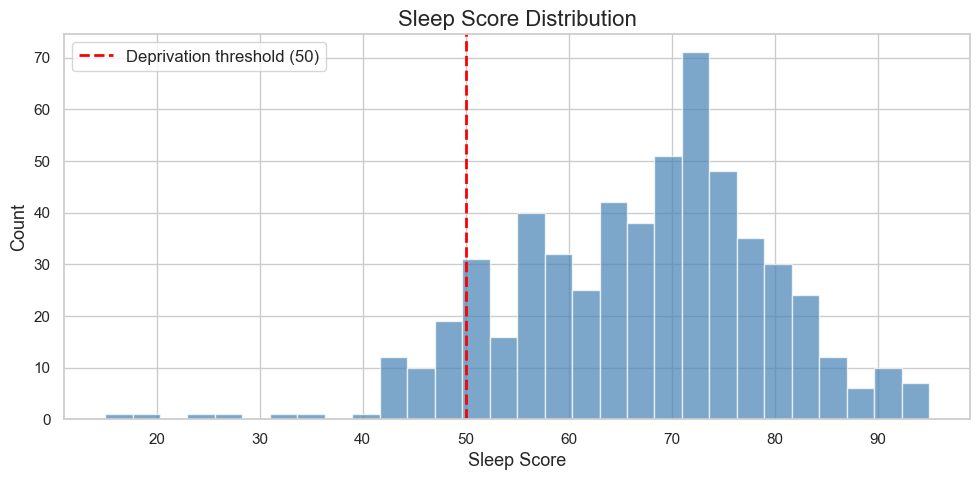

Score stats: mean=66.9, median=69.0, std=12.4
Scores below 50: 48 (8.5%)


In [5]:
# Sleep score distribution with threshold
fig, ax = plt.subplots(figsize=(10, 5))
scored = df['score'].dropna()
ax.hist(scored, bins=30, edgecolor='white', alpha=0.7, color='steelblue')
ax.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Deprivation threshold (50)')
ax.set_title('Sleep Score Distribution')
ax.set_xlabel('Sleep Score')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Score stats: mean={scored.mean():.1f}, median={scored.median():.1f}, std={scored.std():.1f}')
print(f'Scores below 50: {(scored < 50).sum()} ({(scored < 50).mean()*100:.1f}%)')

## 3. Correlation Analysis: Sleep Score vs Daytime Metrics

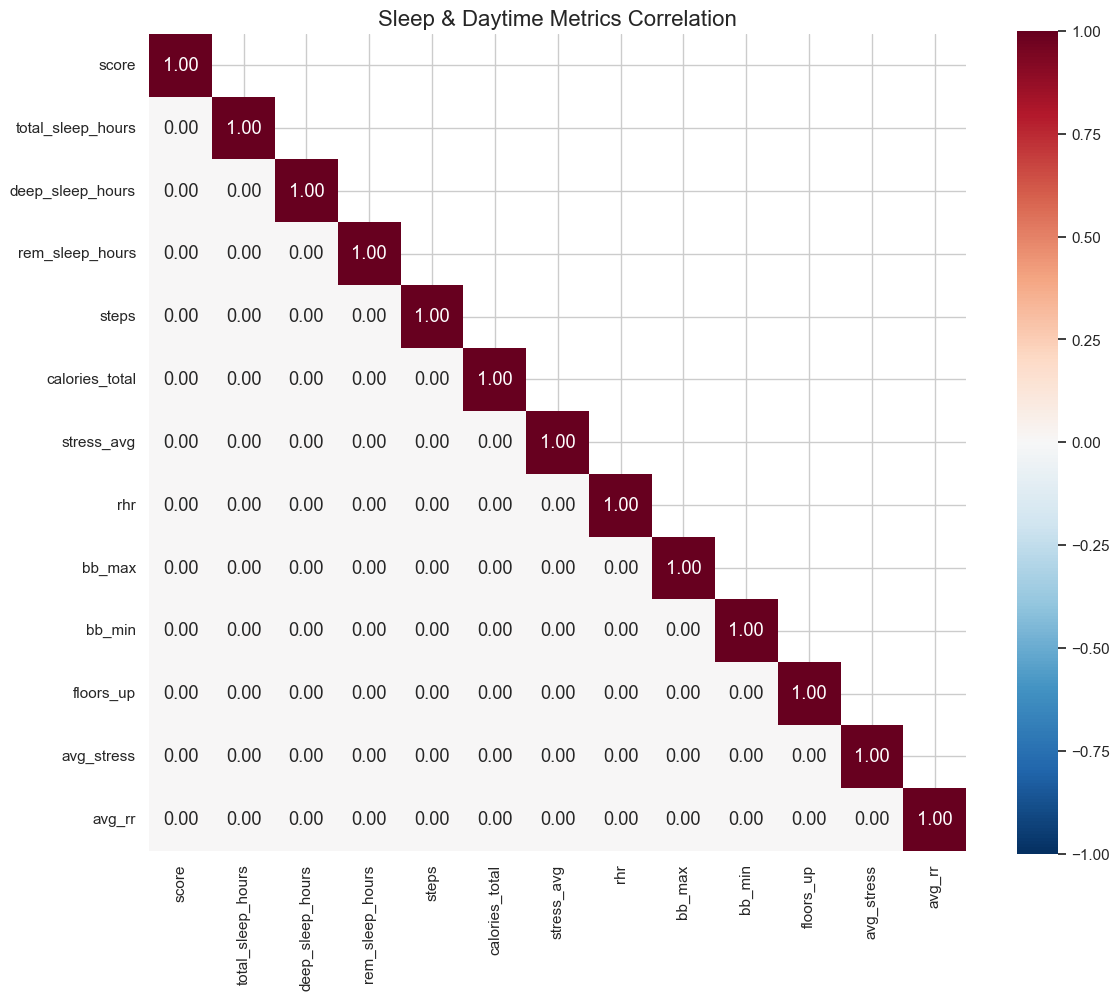

In [6]:
# Correlation heatmap
heatmap_cols = [
    'score', 'total_sleep_hours', 'deep_sleep_hours', 'rem_sleep_hours',
    'steps', 'calories_total', 'stress_avg', 'rhr',
    'bb_max', 'bb_min', 'floors_up',
    'avg_stress', 'avg_rr',
]
corr_mat, p_mat = plot_correlation_heatmap(df, heatmap_cols, title='Sleep & Daytime Metrics Correlation')

In [7]:
# Ranked correlations with sleep score
feature_cols = [
    'steps', 'calories_total', 'stress_avg', 'rhr', 'bb_max', 'bb_min',
    'floors_up', 'rhr_daily', 'avg_stress', 'avg_rr',
    'total_sleep_hours', 'deep_sleep_hours', 'rem_sleep_hours',
    'moderate_activity_time_hours', 'vigorous_activity_time_hours',
]
corr_table = compute_correlations(df, 'score', feature_cols)
print('Spearman Correlations with Sleep Score (ranked by |r|)')
print('=' * 65)
display(corr_table.style.map(
    lambda v: 'font-weight: bold' if v is True else '',
    subset=['significant']
))

Spearman Correlations with Sleep Score (ranked by |r|)


,feature,correlation,p_value,significant
0,rem_sleep_hours,0.826300,0.000000,True
1,total_sleep_hours,0.760100,0.000000,True
2,bb_max,0.630800,0.000000,True
3,avg_stress,-0.444800,0.000000,True
4,stress_avg,-0.380200,0.000000,True
5,rhr,-0.323800,0.000000,True
6,rhr_daily,-0.323800,0.000000,True
7,bb_min,0.296300,0.000000,True
8,avg_rr,-0.107400,0.010725,True
9,vigorous_activity_time_hours,0.094500,0.024608,True


## 4. Group Comparison: Deprived vs Adequate Nights

Group "Deprived": n=104
Group "Adequate": n=497


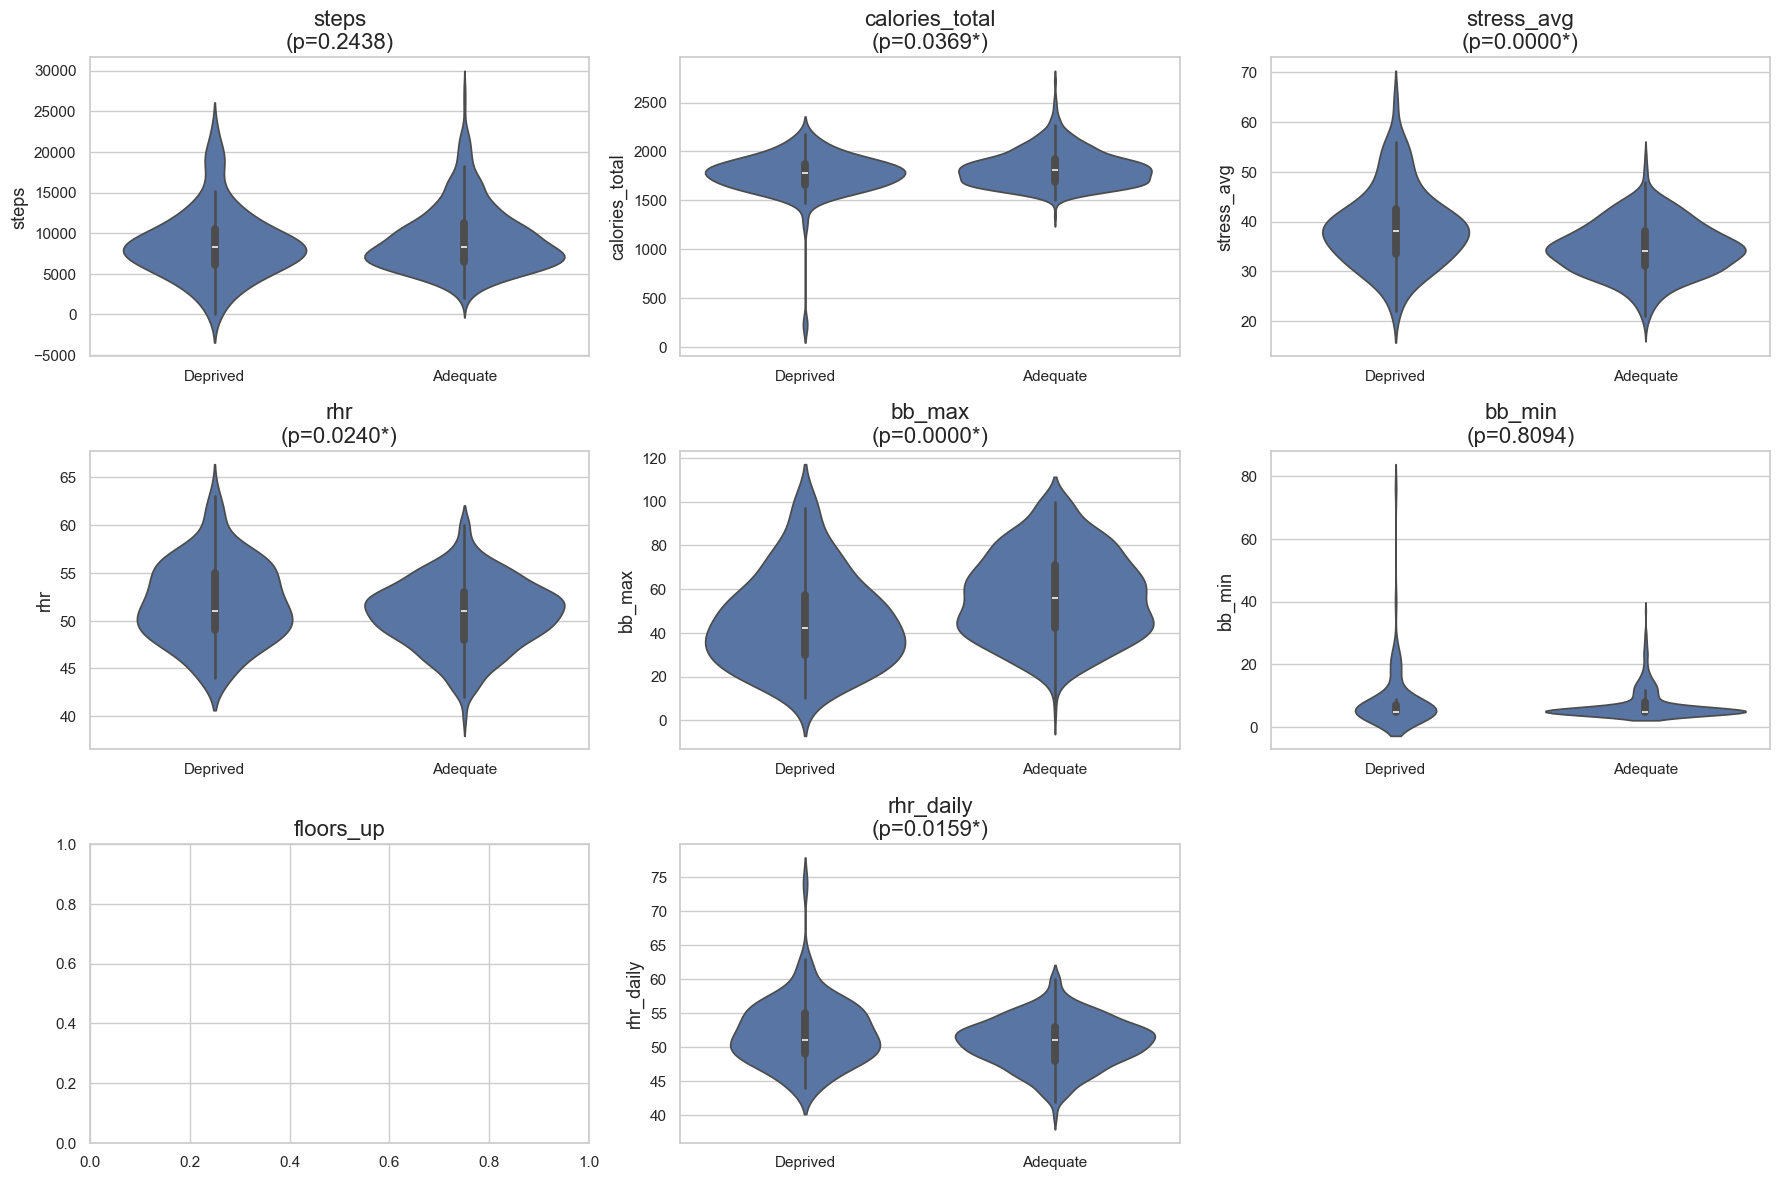

In [8]:
comparison_metrics = [
    'steps', 'calories_total', 'stress_avg', 'rhr',
    'bb_max', 'bb_min', 'floors_up', 'rhr_daily',
]

# Check sample sizes
for group in df['sleep_quality'].unique():
    n = (df['sleep_quality'] == group).sum()
    if n < 10:
        print(f'⚠️  WARNING: Group "{group}" has only {n} samples — results may be unreliable')
    else:
        print(f'Group "{group}": n={n}')

plot_group_comparison(df, 'sleep_quality', comparison_metrics, title_prefix='')

In [9]:
# Detailed group comparison table
print('Mann-Whitney U Test Results: Deprived vs Adequate')
print('=' * 70)
for metric in comparison_metrics:
    try:
        result = compare_groups(df, 'sleep_quality', metric)
        sig = '***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else ''
        print(f'\n{metric}:')
        for grp, s in result['group_stats'].items():
            print(f'  {grp}: mean={s["mean"]}, median={s["median"]}, n={s["n"]}')
        print(f'  p-value={result["p_value"]}{sig}  effect_size={result["effect_size"]}')
    except Exception as e:
        print(f'\n{metric}: Error — {e}')

Mann-Whitney U Test Results: Deprived vs Adequate

steps:
  Deprived: mean=8717.75, median=8269.0, n=91
  Adequate: mean=9316.87, median=8315.0, n=497
  p-value=0.24382  effect_size=0.0768

calories_total:
  Deprived: mean=1763.4, median=1781.0, n=91
  Adequate: mean=1830.31, median=1807.0, n=497
  p-value=0.036856*  effect_size=0.1376

stress_avg:
  Deprived: mean=38.88, median=38.0, n=91
  Adequate: mean=34.56, median=34.0, n=497
  p-value=0.0***  effect_size=-0.3325

rhr:
  Deprived: mean=51.91, median=51.0, n=90
  Adequate: mean=50.71, median=51.0, n=497
  p-value=0.023951*  effect_size=-0.149

bb_max:
  Deprived: mean=45.75, median=42.0, n=91
  Adequate: mean=57.05, median=56.0, n=497
  p-value=1e-06***  effect_size=0.3252

bb_min:
  Deprived: mean=8.62, median=5.0, n=91
  Adequate: mean=7.4, median=5.0, n=497
  p-value=0.809372  effect_size=0.0132

floors_up: Error — 'p_value'

rhr_daily:
  Deprived: mean=52.15, median=51.0, n=91
  Adequate: mean=50.71, median=51.0, n=497
  p-val

## 5. Activity Timing & Sleep Quality

In [10]:
# Load activities and join with sleep data
from customized.data_preproccess_customizers import filter_nighttime_activities

activities = load_activities(group_rare=True)
activities = filter_nighttime_activities(activities)
print(f'Loaded {len(activities)} activities (after nighttime filter)')
print(f'Time bucket distribution:\n{activities["time_bucket"].value_counts().to_string()}')
print(f'\nSport types (grouped):\n{activities["sport_grouped"].value_counts().to_string()}')

Filtered 253 nighttime activities (22:30–04:00 window)
Loaded 362 activities (after nighttime filter)
Time bucket distribution:
time_bucket
Evening       150
Morning        76
Late Night     74
Afternoon      62

Sport types (grouped):
sport_grouped
fitness_equipment    251
basketball            41
cycling               27
running               26
Other                 17


In [11]:
# For each day with activity, get the latest activity's time bucket
# Then merge with sleep data for that night
daily_acts = activities.groupby('date').agg(
    n_activities=('activity_id', 'count'),
    latest_bucket=('time_bucket', 'last'),
    total_elapsed_hours=('elapsed_time_hours', 'sum'),
    primary_sport=('sport_grouped', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0]),
    max_avg_hr=('avg_hr', 'max'),
).reset_index()

# Merge with sleep (activity date = sleep day, since sleep is recorded for the night starting that day)
sleep_act = df.merge(daily_acts, left_on='day', right_on='date', how='left')
sleep_act['had_exercise'] = sleep_act['n_activities'].notna()

print(f'Days with exercise: {sleep_act["had_exercise"].sum()}')
print(f'Rest days: {(~sleep_act["had_exercise"]).sum()}')

Days with exercise: 269
Rest days: 332


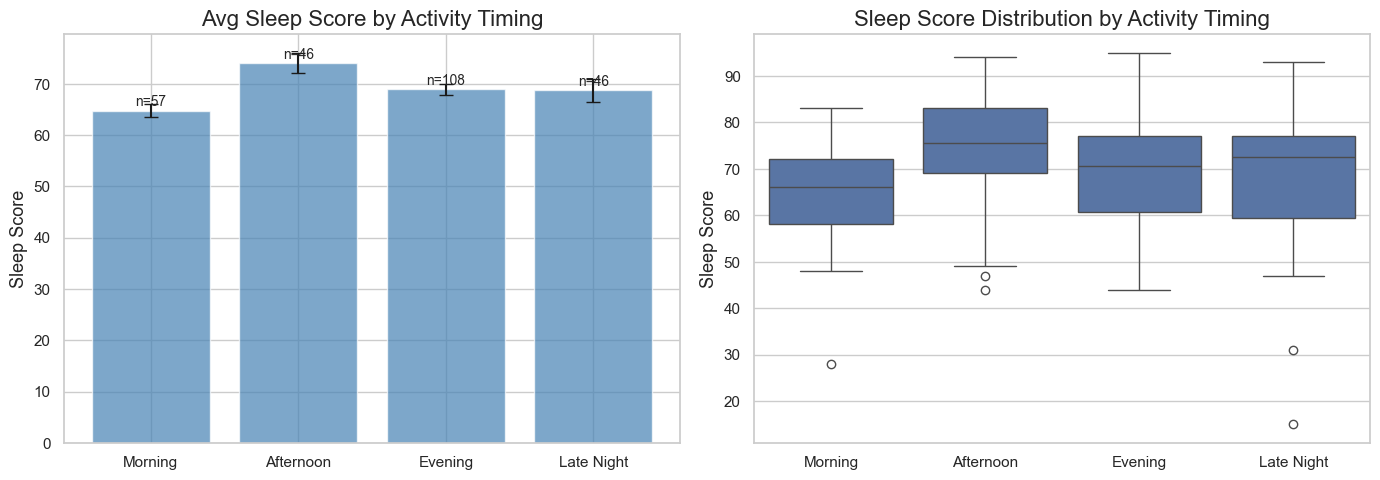

In [12]:
# Sleep quality by activity timing bucket
exercise_days = sleep_act[sleep_act['had_exercise']].copy()

bucket_order = ['Morning', 'Afternoon', 'Evening', 'Late Night']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: avg sleep score by bucket
bucket_scores = exercise_days.groupby('latest_bucket')['score'].agg(['mean', 'count', 'std'])
bucket_scores = bucket_scores.reindex(bucket_order)
ax = axes[0]
bars = ax.bar(bucket_scores.index, bucket_scores['mean'], 
              yerr=bucket_scores['std'] / np.sqrt(bucket_scores['count']),
              color='steelblue', alpha=0.7, capsize=5)
for i, (idx, row) in enumerate(bucket_scores.iterrows()):
    n = int(row['count'])
    label = f'n={n}'
    if n < 10:
        label += ' ⚠️'
    ax.text(i, row['mean'] + 1, label, ha='center', fontsize=10)
ax.set_title('Avg Sleep Score by Activity Timing')
ax.set_ylabel('Sleep Score')

# Box plot by bucket
ax = axes[1]
sns.boxplot(data=exercise_days, x='latest_bucket', y='score', order=bucket_order, ax=ax)
ax.set_title('Sleep Score Distribution by Activity Timing')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('')

plt.tight_layout()
plt.show()

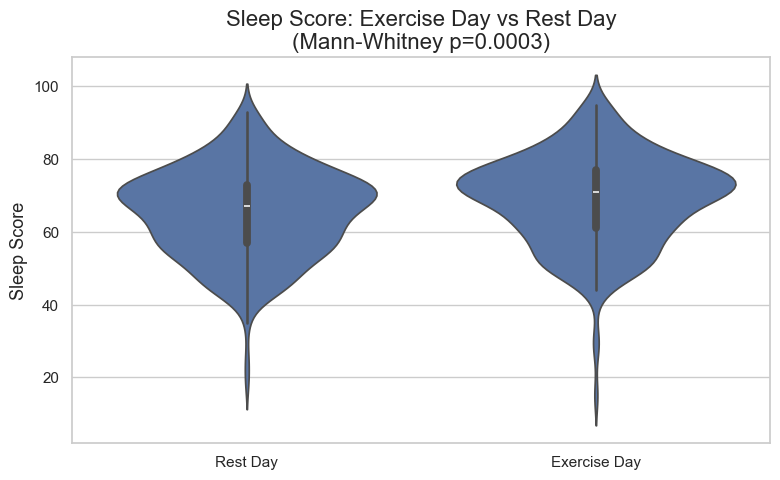

Exercise days: mean=68.8, median=71, n=257
Rest days:     mean=65.3, median=67, n=309


In [13]:
# Exercise day vs rest day comparison
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=sleep_act, x='had_exercise', y='score', inner='box', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Rest Day', 'Exercise Day'])
ax.set_title('Sleep Score: Exercise Day vs Rest Day')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('')

# Mann-Whitney test
exercise_scores = sleep_act.loc[sleep_act['had_exercise'], 'score'].dropna()
rest_scores = sleep_act.loc[~sleep_act['had_exercise'], 'score'].dropna()
stat, pval = stats.mannwhitneyu(exercise_scores, rest_scores, alternative='two-sided')
ax.set_title(f'Sleep Score: Exercise Day vs Rest Day\n(Mann-Whitney p={pval:.4f})')

plt.tight_layout()
plt.show()

print(f'Exercise days: mean={exercise_scores.mean():.1f}, median={exercise_scores.median():.0f}, n={len(exercise_scores)}')
print(f'Rest days:     mean={rest_scores.mean():.1f}, median={rest_scores.median():.0f}, n={len(rest_scores)}')

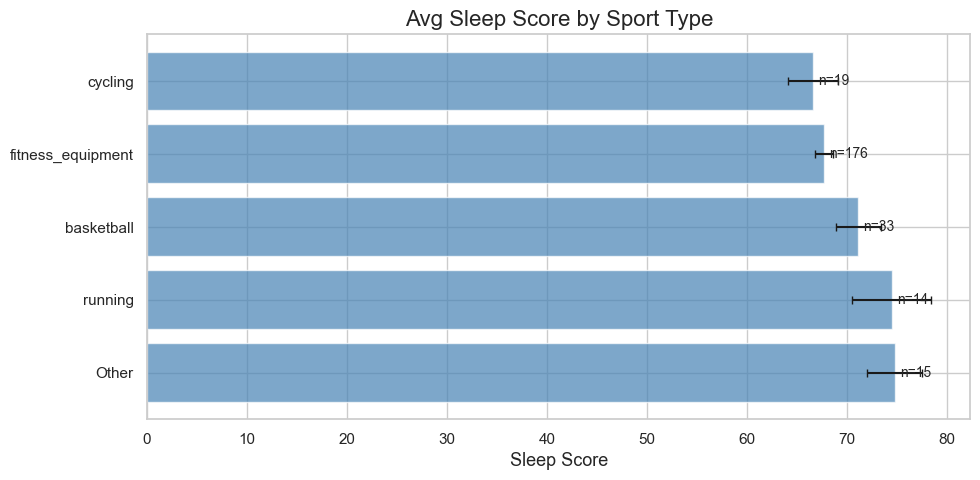

In [14]:
# Sport type analysis
sport_scores = exercise_days.groupby('primary_sport')['score'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(sport_scores.index, sport_scores['mean'], 
               xerr=sport_scores['std'] / np.sqrt(sport_scores['count']),
               color='steelblue', alpha=0.7, capsize=3)
for i, (idx, row) in enumerate(sport_scores.iterrows()):
    n = int(row['count'])
    label = f'n={n}'
    if n < 10:
        label += ' ⚠️'
    ax.text(row['mean'] + 0.5, i, label, va='center', fontsize=10)
ax.set_title('Avg Sleep Score by Sport Type')
ax.set_xlabel('Sleep Score')
plt.tight_layout()
plt.show()

## 5b. Activity Type — Deep Impact Analysis

How does the type of exercise (not just timing) relate to sleep quality?

/var/folders/3_/s_6vtgb51bz0pbkr9147ky_h0000gn/T/ipykernel_86749/1397819477.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, labels=sport_order, patch_artist=True, vert=True,


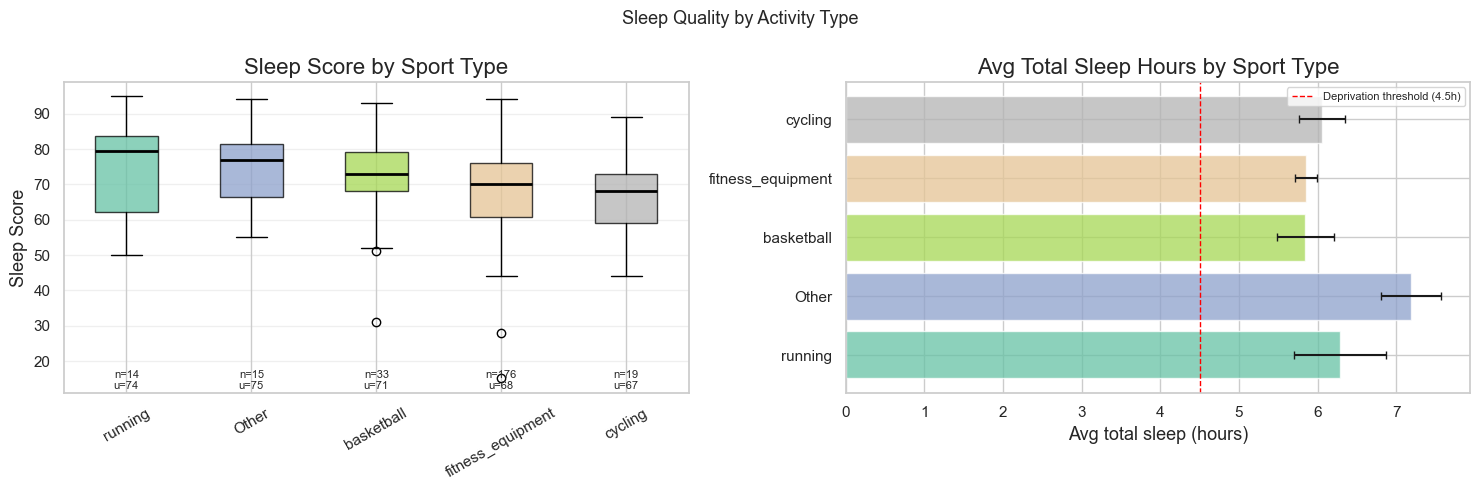

Kruskal-Wallis test across sport types: H=11.92, p=0.0179


In [15]:
# Box plot: sleep score distribution per sport type (n >= 8)
from scipy.stats import mannwhitneyu, kruskal

sport_counts = exercise_days['primary_sport'].value_counts()
major_sports = sport_counts[sport_counts >= 8].index.tolist()
sport_data = exercise_days[exercise_days['primary_sport'].isin(major_sports)].copy()

sport_order = (
    sport_data.groupby('primary_sport')['score'].median()
    .sort_values(ascending=False).index.tolist()
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
ax = axes[0]
groups = [sport_data[sport_data['primary_sport'] == s]['score'].dropna().values
          for s in sport_order]
bp = ax.boxplot(groups, labels=sport_order, patch_artist=True, vert=True,
                medianprops={'color': 'black', 'linewidth': 2})
colors = plt.cm.Set2(np.linspace(0, 1, len(sport_order)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color); patch.set_alpha(0.75)
for i, (grp, s) in enumerate(zip(groups, sport_order)):
    label = 'n={}\nu={:.0f}'.format(len(grp), np.mean(grp))
    ax.text(i + 1, ax.get_ylim()[0] + 1, label, ha='center', fontsize=8)
ax.set_ylabel('Sleep Score')
ax.set_title('Sleep Score by Sport Type')
ax.tick_params(axis='x', rotation=30)
ax.grid(axis='y', alpha=0.3)

# Sleep hours by sport
ax = axes[1]
sport_sleep = sport_data.groupby('primary_sport')['total_sleep_hours'].agg(['mean', 'std', 'count'])
sport_sleep = sport_sleep.reindex(sport_order)
ax.barh(sport_sleep.index, sport_sleep['mean'],
        xerr=sport_sleep['std'] / np.sqrt(sport_sleep['count']),
        color=colors, alpha=0.75, capsize=3)
ax.axvline(4.5, color='red', linestyle='--', linewidth=1, label='Deprivation threshold (4.5h)')
ax.set_xlabel('Avg total sleep (hours)')
ax.set_title('Avg Total Sleep Hours by Sport Type')
ax.legend(fontsize=8)

plt.suptitle('Sleep Quality by Activity Type', fontsize=13)
plt.tight_layout()
plt.show()

# Kruskal-Wallis across all sport types
if len(groups) >= 2:
    h, p_kw = kruskal(*[g for g in groups if len(g) >= 3])
    print(f'Kruskal-Wallis test across sport types: H={h:.2f}, p={p_kw:.4f}')

In [16]:
# Deprivation rate + effect size per sport type vs rest days
rest_scores = sleep_act[~sleep_act['had_exercise']]['score'].dropna().values
rest_dep_rate = sleep_act[~sleep_act['had_exercise']]['is_deprived'].mean() * 100

rows = []
for sport in sport_order:
    sub = sport_data[sport_data['primary_sport'] == sport]['score'].dropna().values
    dep_rate = sport_data[sport_data['primary_sport'] == sport]['is_deprived'].mean() * 100
    if len(sub) < 5:
        continue
    u, p = mannwhitneyu(sub, rest_scores, alternative='two-sided')
    effect = 1 - (2 * u) / (len(sub) * len(rest_scores))
    rows.append({
        'sport': sport,
        'n': len(sub),
        'mean_score': round(float(np.mean(sub)), 1),
        'deprivation_rate_%': round(dep_rate, 1),
        'effect_vs_rest': round(float(effect), 3),
        'p_vs_rest': round(float(p), 4),
    })

sport_stats = pd.DataFrame(rows).sort_values('mean_score', ascending=False)
print(f'Rest days: n={len(rest_scores)}, mean score={np.mean(rest_scores):.1f}, deprivation rate={rest_dep_rate:.1f}%')
print()
print(sport_stats.to_string(index=False))

Rest days: n=309, mean score=65.3, deprivation rate=21.4%

            sport   n  mean_score  deprivation_rate_%  effect_vs_rest  p_vs_rest
            Other  15        74.8                 0.0          -0.444     0.0037
          running  14        74.5                13.3          -0.395     0.0125
       basketball  33        71.2                11.1          -0.303     0.0043
fitness_equipment 176        67.7                14.1          -0.125     0.0216
          cycling  19        66.6                 5.3          -0.042     0.7619


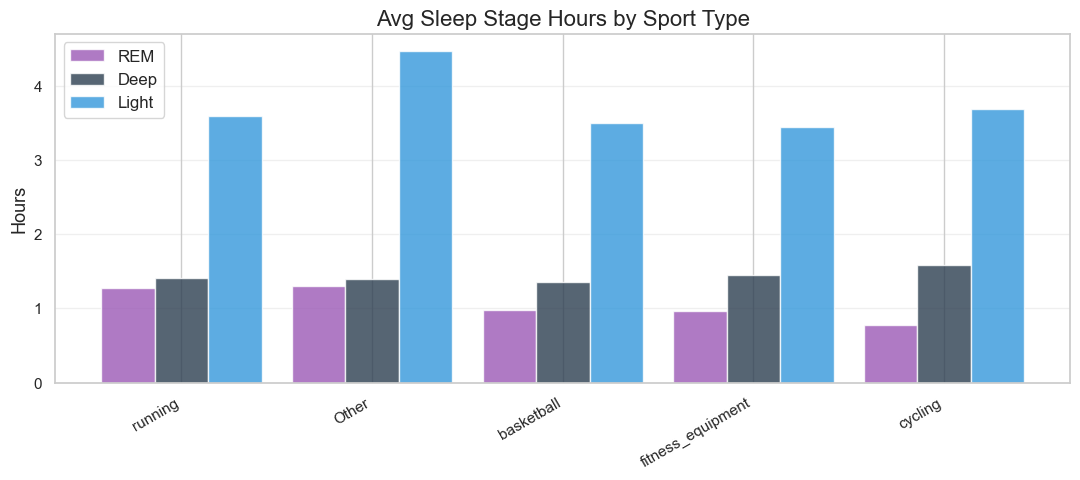

In [17]:
# Sleep stage breakdown by sport type
stage_cols = ["rem_sleep_hours", "deep_sleep_hours", "light_sleep_hours"]
stage_labels = ["REM", "Deep", "Light"]
stage_colors = ["#9b59b6", "#2c3e50", "#3498db"]

stage_by_sport = sport_data.groupby("primary_sport")[stage_cols].mean().reindex(sport_order)

fig, ax = plt.subplots(figsize=(11, 5))
x = np.arange(len(sport_order))
width = 0.28
for i, (col, label, color) in enumerate(zip(stage_cols, stage_labels, stage_colors)):
    ax.bar(x + i * width, stage_by_sport[col], width, label=label, color=color, alpha=0.8)
ax.set_xticks(x + width)
ax.set_xticklabels(sport_order, rotation=30, ha="right")
ax.set_ylabel("Hours")
ax.set_title("Avg Sleep Stage Hours by Sport Type")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Temporal Patterns

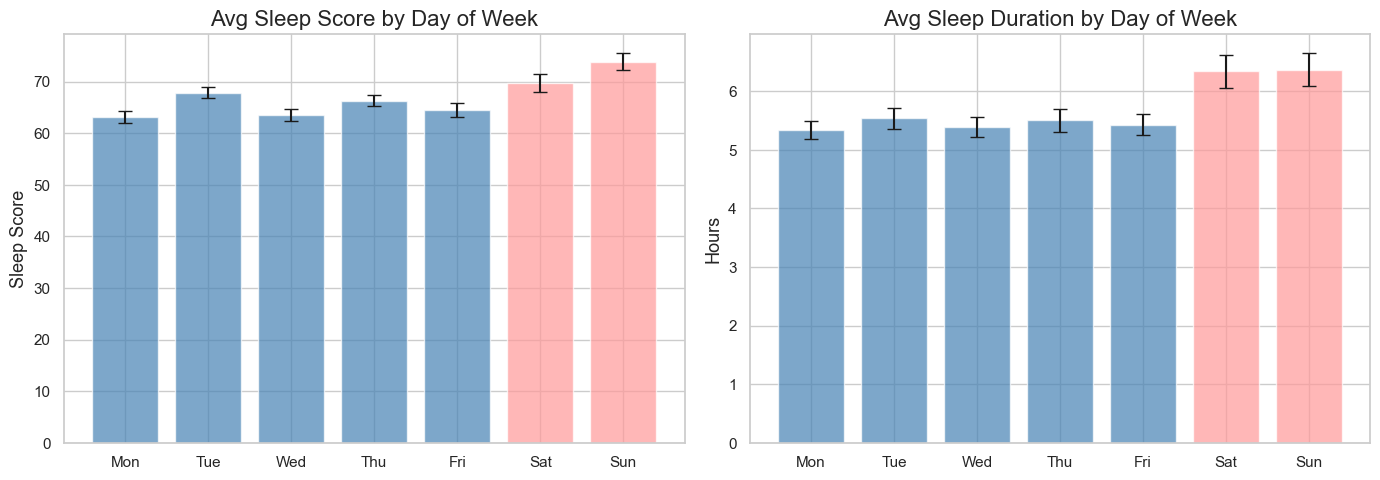

Kruskal-Wallis test (score ~ day_of_week): H=57.25, p=0.0000


In [18]:
# Day of week analysis
df['day_of_week'] = df['day'].dt.day_name()
df['dow_num'] = df['day'].dt.dayofweek  # 0=Monday
df['is_weekend'] = df['dow_num'].isin([5, 6])

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = df.groupby('day_of_week')['score'].agg(['mean', 'count', 'std']).reindex(dow_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax = axes[0]
colors = ['#ff9999' if d in ['Saturday', 'Sunday'] else 'steelblue' for d in dow_order]
ax.bar(range(7), dow_stats['mean'], 
       yerr=dow_stats['std'] / np.sqrt(dow_stats['count']),
       color=colors, alpha=0.7, capsize=5)
ax.set_xticks(range(7))
ax.set_xticklabels([d[:3] for d in dow_order])
ax.set_title('Avg Sleep Score by Day of Week')
ax.set_ylabel('Sleep Score')

# Also show duration
dow_duration = df.groupby('day_of_week')['total_sleep_hours'].agg(['mean', 'count', 'std']).reindex(dow_order)
ax = axes[1]
ax.bar(range(7), dow_duration['mean'],
       yerr=dow_duration['std'] / np.sqrt(dow_duration['count']),
       color=colors, alpha=0.7, capsize=5)
ax.set_xticks(range(7))
ax.set_xticklabels([d[:3] for d in dow_order])
ax.set_title('Avg Sleep Duration by Day of Week')
ax.set_ylabel('Hours')

plt.tight_layout()
plt.show()

# Kruskal-Wallis test across days
day_groups = [df.loc[df['day_of_week'] == d, 'score'].dropna() for d in dow_order]
stat, pval = stats.kruskal(*day_groups)
print(f'Kruskal-Wallis test (score ~ day_of_week): H={stat:.2f}, p={pval:.4f}')

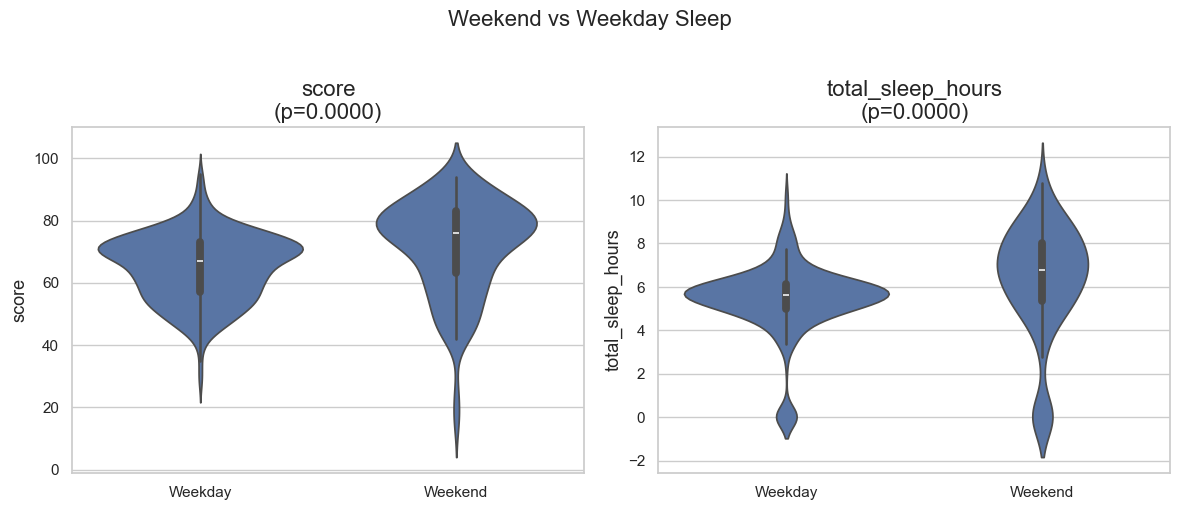

score: Weekday mean=65.0 | Weekend mean=71.7
total_sleep_hours: Weekday mean=5.4 | Weekend mean=6.3


In [19]:
# Weekend vs weekday comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, metric in enumerate(['score', 'total_sleep_hours']):
    ax = axes[i]
    sns.violinplot(data=df, x='is_weekend', y=metric, inner='box', ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Weekday', 'Weekend'])
    
    # Mann-Whitney
    weekday_vals = df.loc[~df['is_weekend'], metric].dropna()
    weekend_vals = df.loc[df['is_weekend'], metric].dropna()
    stat, pval = stats.mannwhitneyu(weekday_vals, weekend_vals, alternative='two-sided')
    ax.set_title(f'{metric}\n(p={pval:.4f})')
    ax.set_xlabel('')

plt.suptitle('Weekend vs Weekday Sleep', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print stats
for metric in ['score', 'total_sleep_hours']:
    weekday = df.loc[~df['is_weekend'], metric].dropna()
    weekend = df.loc[df['is_weekend'], metric].dropna()
    print(f'{metric}: Weekday mean={weekday.mean():.1f} | Weekend mean={weekend.mean():.1f}')

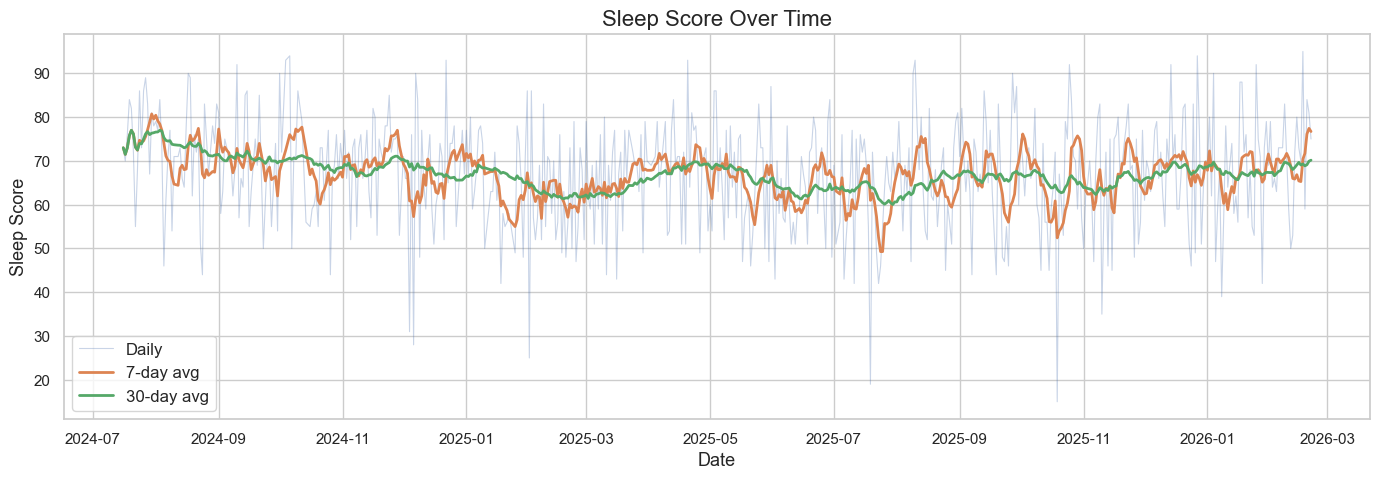

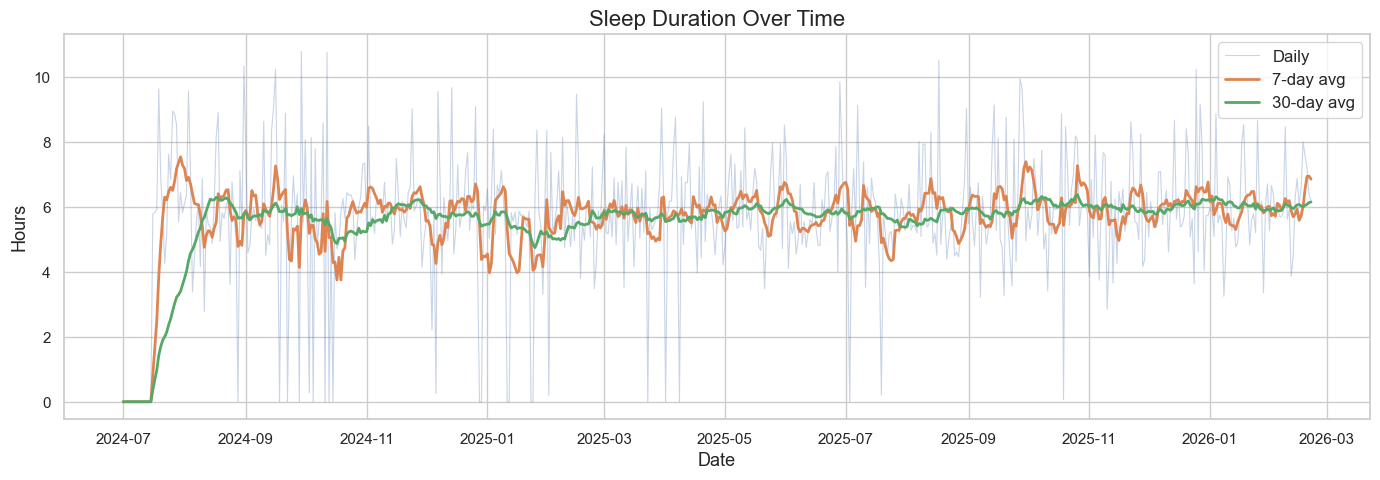

In [20]:
# Time series with rolling averages
plot_time_series(df, 'day', 'score', [7, 30],
                 title='Sleep Score Over Time', ylabel='Sleep Score')

plot_time_series(df, 'day', 'total_sleep_hours', [7, 30],
                 title='Sleep Duration Over Time', ylabel='Hours')

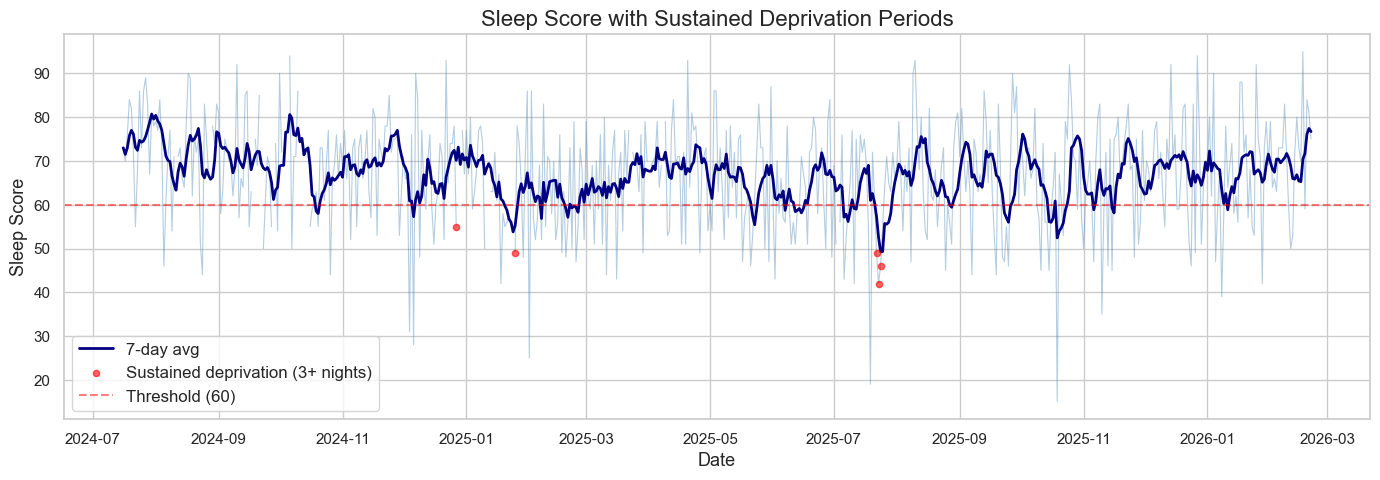

Sustained deprivation episodes (3+ consecutive nights): 4
Streak lengths: [15, 3, 3, 3]
Longest streak: 15 nights


In [21]:
# Sustained sleep deprivation detection (3+ consecutive deprived nights)
df_sorted = df.sort_values('day').copy()
df_sorted['deprived_streak'] = 0
streak = 0
streaks = []
for i, row in df_sorted.iterrows():
    if row['is_deprived']:
        streak += 1
    else:
        if streak >= 3:
            streaks.append(streak)
        streak = 0
    df_sorted.at[i, 'deprived_streak'] = streak
if streak >= 3:
    streaks.append(streak)

# Plot with highlighted sustained deprivation periods
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_sorted['day'], df_sorted['score'], alpha=0.4, linewidth=0.8, color='steelblue')
rolled = df_sorted['score'].rolling(7, min_periods=1).mean()
ax.plot(df_sorted['day'], rolled, linewidth=2, color='navy', label='7-day avg')

# Highlight 3+ consecutive deprived nights
in_streak = df_sorted['deprived_streak'] >= 3
# Also mark the start of streaks (where streak count is 3, and 2 nights before)
sustained_mask = pd.Series(False, index=df_sorted.index)
for i, row in df_sorted.iterrows():
    if row['deprived_streak'] >= 3:
        sustained_mask.at[i] = True
    elif row['is_deprived'] and row['deprived_streak'] >= 1:
        # Check if this is part of a streak that will reach 3+
        idx_pos = df_sorted.index.get_loc(i)
        look_ahead = min(idx_pos + 3, len(df_sorted))
        if any(df_sorted.iloc[idx_pos:look_ahead]['deprived_streak'] >= 3):
            sustained_mask.at[i] = True

sustained_days = df_sorted[sustained_mask]
ax.scatter(sustained_days['day'], sustained_days['score'], 
           color='red', s=20, alpha=0.6, zorder=5, label='Sustained deprivation (3+ nights)')

ax.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='Threshold (60)')
ax.set_title('Sleep Score with Sustained Deprivation Periods')
ax.set_ylabel('Sleep Score')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Sustained deprivation episodes (3+ consecutive nights): {len(streaks)}')
if streaks:
    print(f'Streak lengths: {sorted(streaks, reverse=True)}')
    print(f'Longest streak: {max(streaks)} nights')

## 7. Sleep Stage Analysis

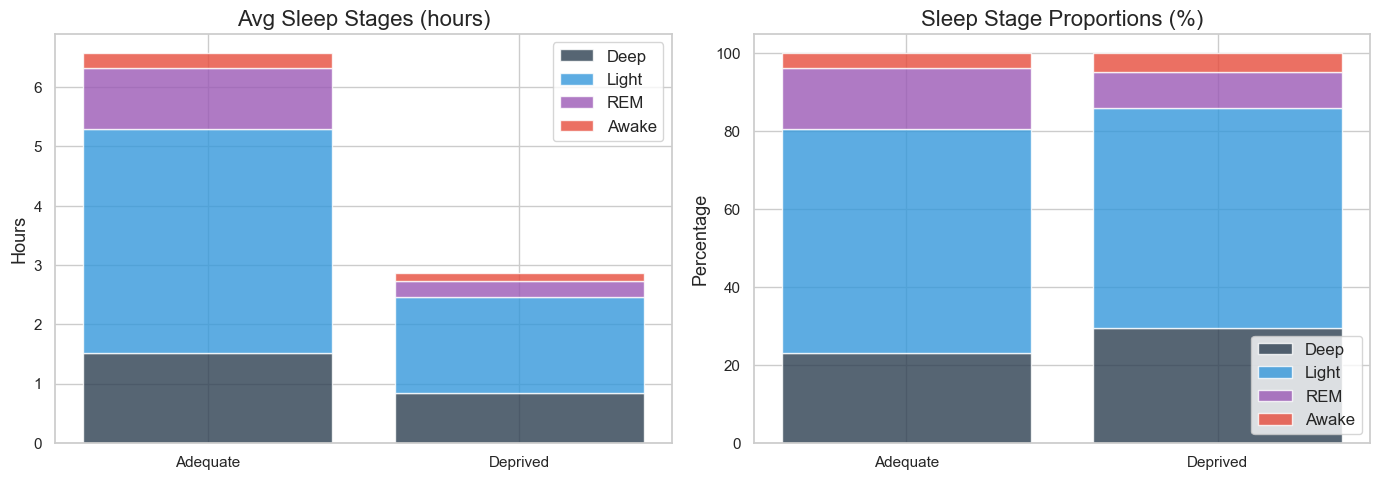

Stage breakdown (hours):


,deep_sleep_hours,light_sleep_hours,rem_sleep_hours,awake_hours
sleep_quality,,,,
Adequate,1.52,3.77,1.02,0.25
Deprived,0.84,1.62,0.26,0.14


In [22]:
# Sleep stage proportions: Deprived vs Adequate
stage_cols = ['deep_sleep_hours', 'light_sleep_hours', 'rem_sleep_hours', 'awake_hours']
stage_labels = ['Deep', 'Light', 'REM', 'Awake']

stage_means = df.groupby('sleep_quality')[stage_cols].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
ax = axes[0]
bottom = np.zeros(len(stage_means))
colors_stages = ['#2c3e50', '#3498db', '#9b59b6', '#e74c3c']
for col, label, color in zip(stage_cols, stage_labels, colors_stages):
    vals = stage_means[col].values
    ax.bar(stage_means.index, vals, bottom=bottom, label=label, color=color, alpha=0.8)
    bottom += vals
ax.set_title('Avg Sleep Stages (hours)')
ax.set_ylabel('Hours')
ax.legend()

# Proportions
ax = axes[1]
stage_pct = stage_means.div(stage_means.sum(axis=1), axis=0) * 100
bottom = np.zeros(len(stage_pct))
for col, label, color in zip(stage_cols, stage_labels, colors_stages):
    vals = stage_pct[col].values
    ax.bar(stage_pct.index, vals, bottom=bottom, label=label, color=color, alpha=0.8)
    bottom += vals
ax.set_title('Sleep Stage Proportions (%)')
ax.set_ylabel('Percentage')
ax.legend()

plt.tight_layout()
plt.show()

print('Stage breakdown (hours):')
display(stage_means.round(2))

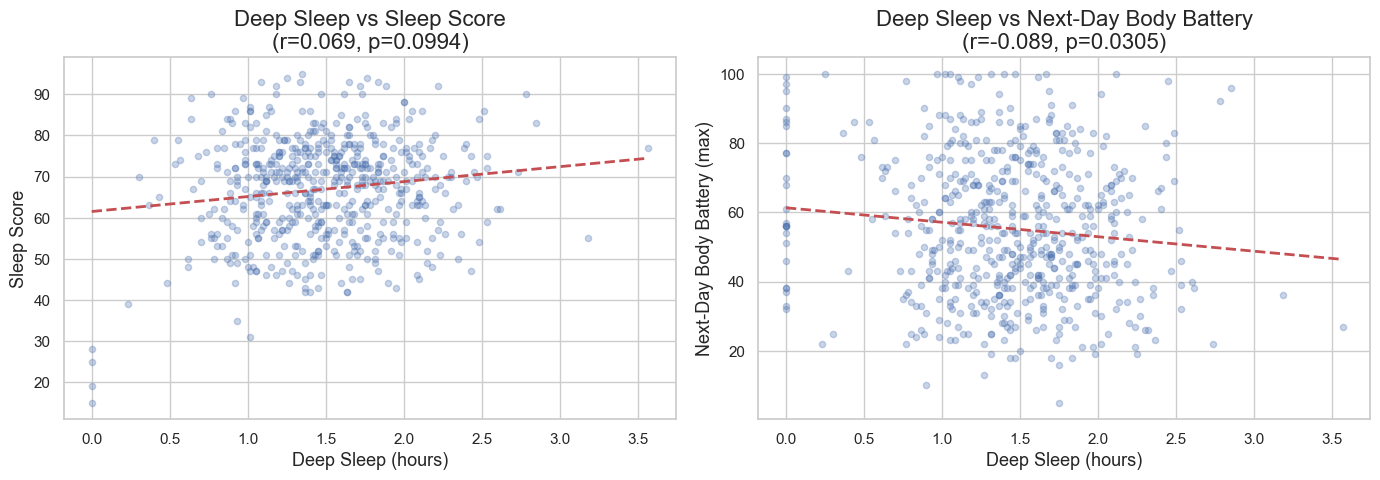

In [23]:
# Deep sleep correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deep sleep vs sleep score
ax = axes[0]
mask = df[['deep_sleep_hours', 'score']].dropna()
ax.scatter(mask['deep_sleep_hours'], mask['score'], alpha=0.3, s=20)
z = np.polyfit(mask['deep_sleep_hours'], mask['score'], 1)
p = np.poly1d(z)
x_range = np.linspace(mask['deep_sleep_hours'].min(), mask['deep_sleep_hours'].max(), 100)
ax.plot(x_range, p(x_range), 'r--', linewidth=2)
r, pval = stats.spearmanr(mask['deep_sleep_hours'], mask['score'])
ax.set_title(f'Deep Sleep vs Sleep Score\n(r={r:.3f}, p={pval:.4f})')
ax.set_xlabel('Deep Sleep (hours)')
ax.set_ylabel('Sleep Score')

# Deep sleep vs next-day body battery
ax = axes[1]
df_shifted = df.sort_values('day').copy()
df_shifted['next_day_bb_max'] = df_shifted['bb_max'].shift(-1)
mask2 = df_shifted[['deep_sleep_hours', 'next_day_bb_max']].dropna()
ax.scatter(mask2['deep_sleep_hours'], mask2['next_day_bb_max'], alpha=0.3, s=20)
z2 = np.polyfit(mask2['deep_sleep_hours'], mask2['next_day_bb_max'], 1)
p2 = np.poly1d(z2)
x_range2 = np.linspace(mask2['deep_sleep_hours'].min(), mask2['deep_sleep_hours'].max(), 100)
ax.plot(x_range2, p2(x_range2), 'r--', linewidth=2)
r2, pval2 = stats.spearmanr(mask2['deep_sleep_hours'], mask2['next_day_bb_max'])
ax.set_title(f'Deep Sleep vs Next-Day Body Battery\n(r={r2:.3f}, p={pval2:.4f})')
ax.set_xlabel('Deep Sleep (hours)')
ax.set_ylabel('Next-Day Body Battery (max)')

plt.tight_layout()
plt.show()

## 8. Key Findings Summary

In [24]:
# Compile all findings programmatically
print('=' * 70)
print('SLEEP DEPRIVATION ANALYSIS — KEY FINDINGS')
print('=' * 70)
print(f'\nDataset: {len(df)} nights ({df["day"].min().date()} to {df["day"].max().date()})')
print(f'Sleep deprived nights: {df["is_deprived"].sum()} ({df["is_deprived"].mean()*100:.1f}%)')
print()

print('--- Top Correlated Factors (with sleep score) ---')
for _, row in corr_table.head(8).iterrows():
    sig = '✓' if row['significant'] else ' '
    direction = '↑' if row['correlation'] > 0 else '↓'
    print(f'  [{sig}] {row["feature"]:30s}  r={row["correlation"]:+.3f}  p={row["p_value"]:.4f}  {direction}')

print()
print('--- Interpretation ---')
print('Positive correlation (↑): higher values associated with BETTER sleep')
print('Negative correlation (↓): higher values associated with WORSE sleep')
print()

print('--- Important Caveats ---')
print('1. Correlation ≠ causation — these are associations, not causal effects')
print('2. Confounding variables exist (e.g., weekends affect both exercise timing and bedtime)')
print('3. Some metrics have circular relationships (e.g., body battery is partially derived from sleep)')
print('4. Individual patterns may differ from aggregate trends')
print('5. Data completeness varies by metric — check Section 1 for details')

SLEEP DEPRIVATION ANALYSIS — KEY FINDINGS

Dataset: 601 nights (2024-07-01 to 2026-02-21)
Sleep deprived nights: 104 (17.3%)

--- Top Correlated Factors (with sleep score) ---
  [✓] rem_sleep_hours                 r=+0.826  p=0.0000  ↑
  [✓] total_sleep_hours               r=+0.760  p=0.0000  ↑
  [✓] bb_max                          r=+0.631  p=0.0000  ↑
  [✓] avg_stress                      r=-0.445  p=0.0000  ↓
  [✓] stress_avg                      r=-0.380  p=0.0000  ↓
  [✓] rhr                             r=-0.324  p=0.0000  ↓
  [✓] rhr_daily                       r=-0.324  p=0.0000  ↓
  [✓] bb_min                          r=+0.296  p=0.0000  ↑

--- Interpretation ---
Positive correlation (↑): higher values associated with BETTER sleep
Negative correlation (↓): higher values associated with WORSE sleep

--- Important Caveats ---
1. Correlation ≠ causation — these are associations, not causal effects
2. Confounding variables exist (e.g., weekends affect both exercise timing and bedti